In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.integrate import trapezoid, quad, simpson
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

from matplotlib import cm

%matplotlib notebook

# Importing data with `pandas`

`df` enty contains batch of I-Vs with captured at different temperatures (from 300K to 400K)

My guess, that reverse current can be described with Termionic Field Emission (TFE) [https://doi.org/10.1063/5.0007715 ] and Poole-Frenkel (PF) [https://en.wikipedia.org/wiki/Poole%E2%80%93Frenkel_effect ] mechanisms.

In [2]:
df = pd.read_excel('JV2.xlsx')

In [3]:
df

,v300,j300,v320,j320,v340,j340,v360,j360,v380,j380,v400,j400,v420,j420
0,-20.0,0.000168,-20.00000,0.000306,-20.00000,0.000383,-20.0,0.000477,-20.0,0.000704,-19.5,0.000865,-20.0,0.00183
1,-19.9,0.000160,-19.90000,0.000293,-19.90000,0.000368,-19.9,0.000458,-19.9,0.000674,-19.4,0.000830,-19.9,0.00176
2,-19.8,0.000153,-19.80000,0.000282,-19.80000,0.000354,-19.8,0.000441,-19.8,0.000646,-19.3,0.000795,-19.8,0.00169
3,-19.7,0.000144,-19.70000,0.000270,-19.70000,0.000340,-19.7,0.000423,-19.7,0.000619,-19.2,0.000764,-19.7,0.00162
4,-19.6,0.000138,-19.60000,0.000260,-19.60001,0.000326,-19.6,0.000406,-19.6,0.000594,-19.1,0.000733,-19.6,0.00155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332,NaN,NaN,1.31000,0.658600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
333,NaN,NaN,1.32000,0.654800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
334,NaN,NaN,1.33000,0.658040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
335,NaN,NaN,1.34000,0.662390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Set temperatures in `Ts` and plot data in axes `ax`

In [4]:
Ts = np.linspace(300, 400, 6, dtype = np.int32)
Ts

array([300, 320, 340, 360, 380, 400], dtype=int32)

<IPython.core.display.Javascript object>


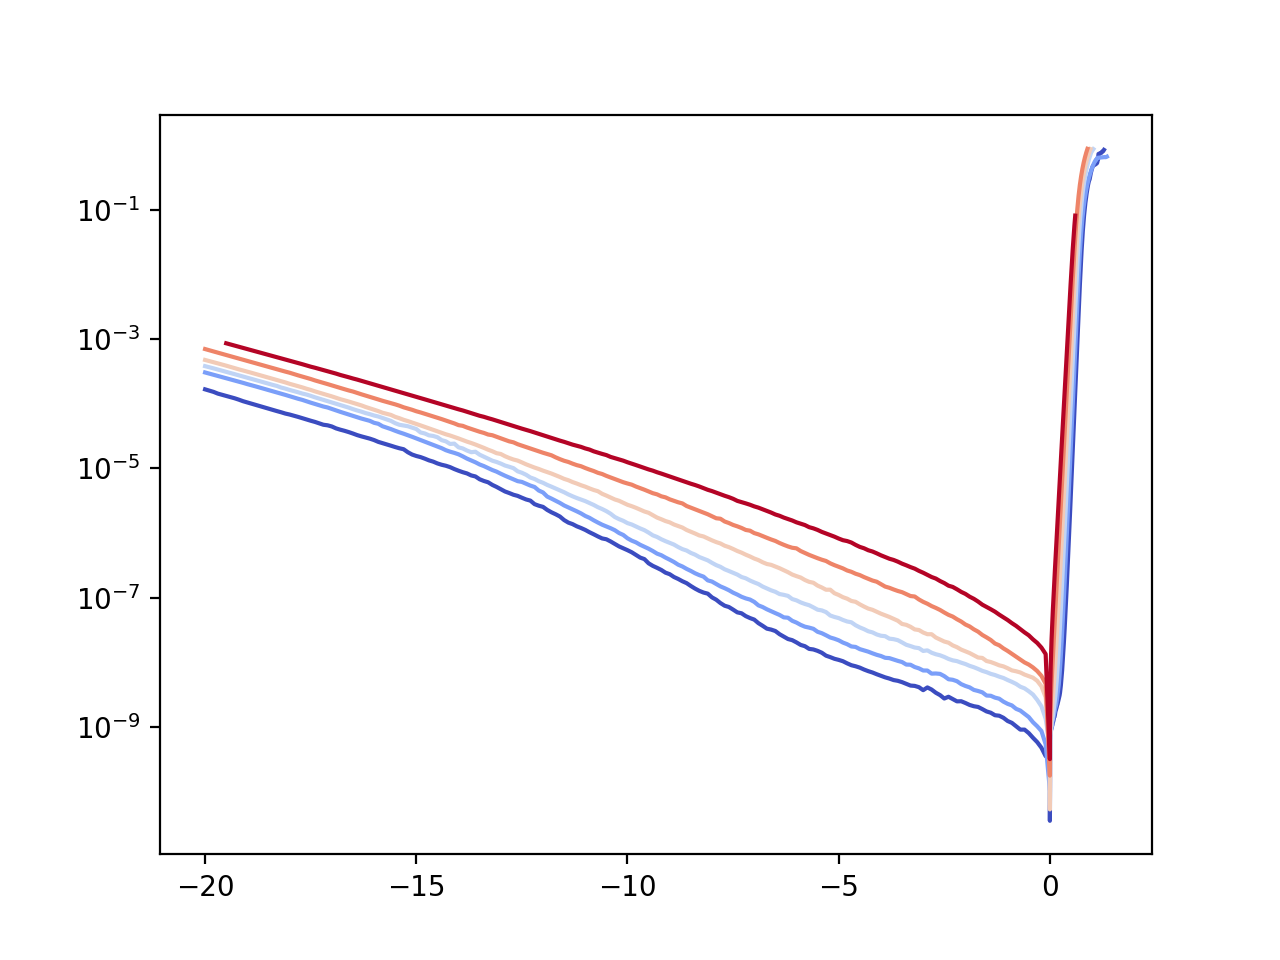

In [5]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_yscale('log')
c = cm.coolwarm(np.linspace(0, 1, len(Ts)))

for _i, _t in enumerate(Ts):
    name = str(_t)
    ax.plot(df['v'+name],df['j'+name], '-', c = c[_i])
    #ax.plot(df['v'+name],df['n'+name], ':', c = c[_i])

# Define constants, fields and potentials

Definition of parameters for TFE and PF models are defined here:

In [6]:
pi = np.pi
meff = 0.34
mt = 0.1
m = 9.11e-31 # kg
eps = 10*8.85e-14 #F/cm
kB = 1.38e-23
q  = 1.602e-19
h  = 6.626e-34
hbar = h/(2*pi)

Temp = 300.0

bi = 1.1 #eV
Nd = 2.63e17 #cm-3
#Nd = 1.0e18

phib = 1.30 #+ 0.1 # From IV fit

# Analytical solution for reverse currents
## Termionic emission with IF barrier lowering

$$J_{TE}(V) = A^{**}T^2\exp{\left(-\frac{q\phi_{B0} - q\Delta \phi}{k_B T}\right)}$$
$$\Delta\phi = \sqrt[4]{\frac{q^3 N_D \left|\phi_{B0}-\phi_n - V_R\right|}{8\pi^2\varepsilon_S^3}}$$

<IPython.core.display.Javascript object>


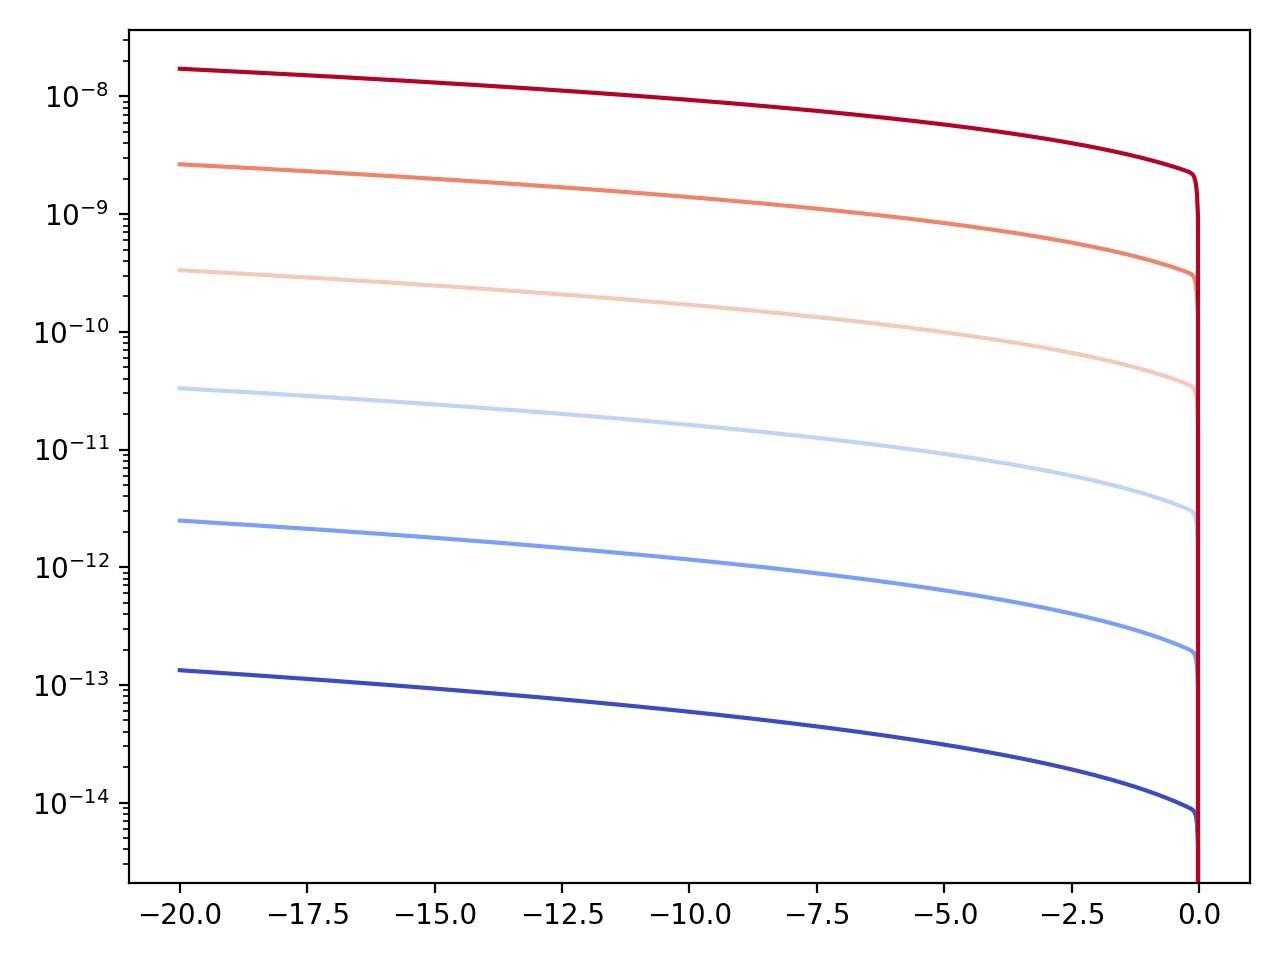

In [7]:
def geta_TE(v, Temp = 300., meff = 0.34, phib = 1.2, Nd = 1.e15):
    """
    Analytical TE model
    
    """
    J0 = 120.*meff*Temp**2
    
    psis = phib - v
    
    Em = np.sqrt(2*q*Nd*np.abs(psis)/eps)
    #print(Em, 'V/cm')
    
    #delta = ((q**2*Nd*np.abs(psis))/(8*pi**2*eps**3))
    delta = np.sqrt(q*Em/(4*pi*eps))
    J = J0*np.exp(-q*(phib - delta)/(kB*Temp))*(np.exp(q*v/kB/Temp) - 1)
    
    return np.abs(J)

v = np.linspace(-20, 0, 1001)
j_TE = geta_TE(v, Temp = 300., meff = meff, phib = phib, Nd = Nd)
    
fig = plt.figure()
ax = fig.add_subplot()
ax.set_yscale('log')

for _i, _t in enumerate(Ts):
    ax.plot(v, geta_TE(v, Temp = _t, meff = meff, phib = phib, Nd = Nd), color = c[_i])
    
plt.tight_layout()

## Field emission

FN-model
$$J_{FE}(V) = A^{**}T^2\frac{\pi\exp\left(-q(\phi_B - V_F)\right)}{c_1}$$

# Define structures and physics


Define finctions to implement

<IPython.core.display.Javascript object>


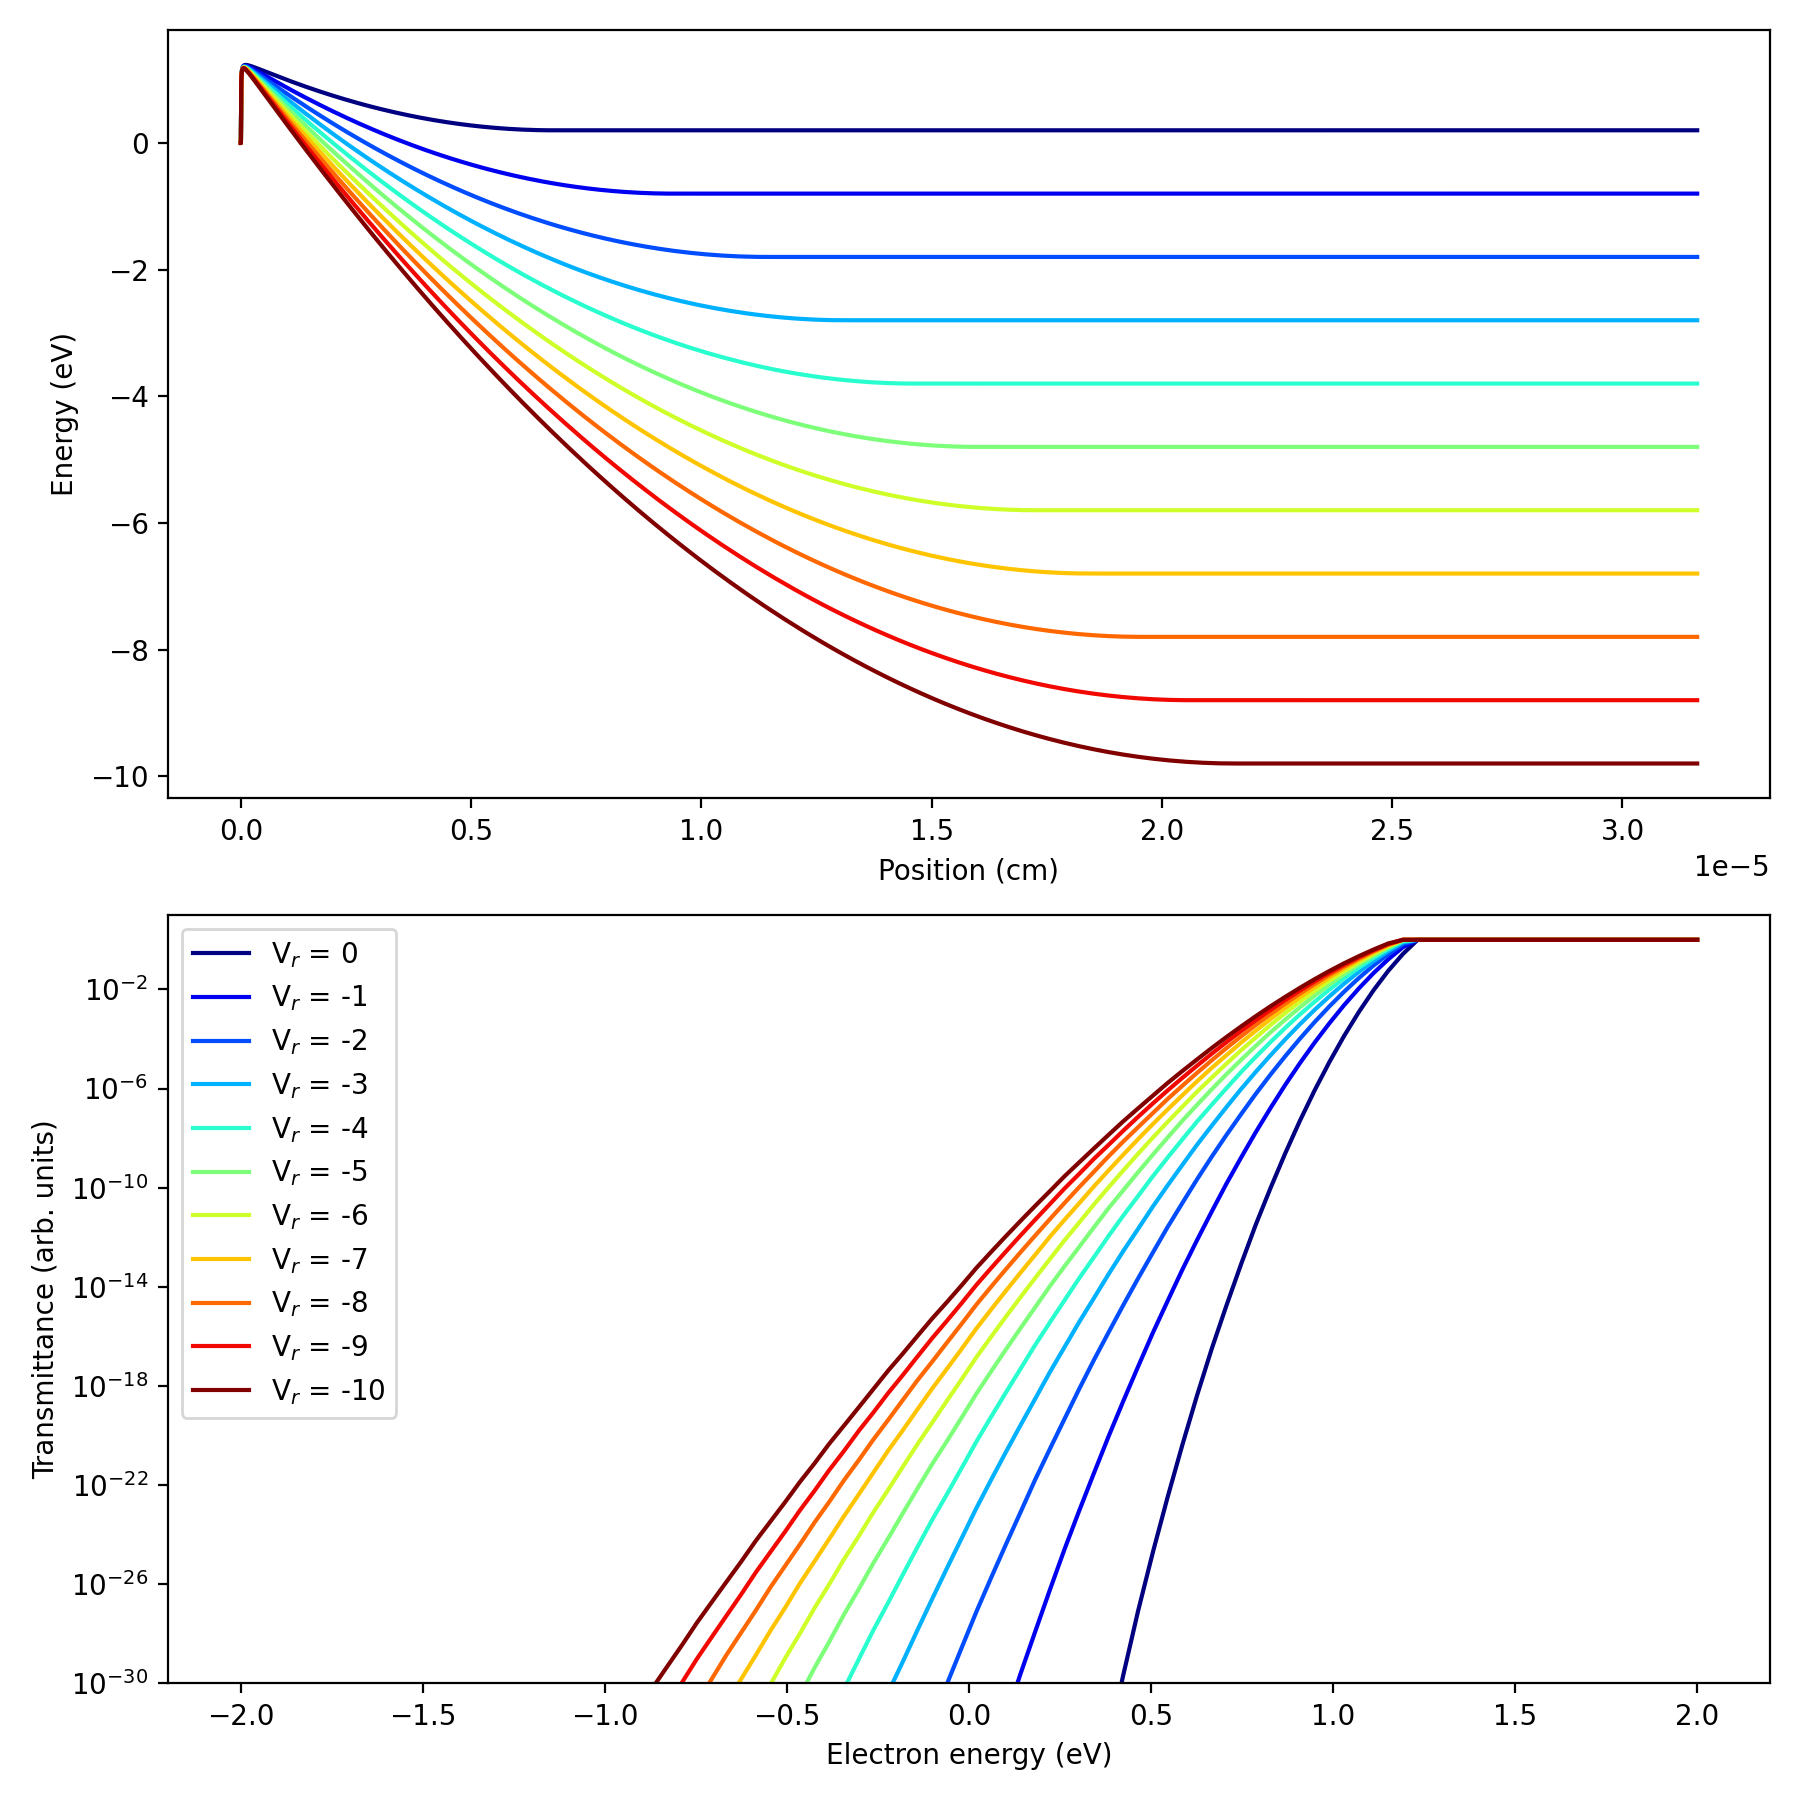

In [8]:
def get_scr(v, bi = 0.3, Nd = 1e15):
    """
    Returns screen charge region width
    from input voltage V
    
    Parameters:
    -----------
    v : array
        voltage across structure in [V]
    bi : float
        Build-in voltage of structure in [eV]
    Nd : float
        Doping concentration in [cm-3]
    
    Returns:
    --------
    wn : array with len(v)
        SCR width in [cm] of structure as a function of v
    """
    v = np.asarray(v, dtype=np.float64)
        
    def wn0(v):
        wn0 = 2*eps*(bi-v)
        wn0 = wn0/(q*Nd)
        return np.sqrt(wn0)

    wn = np.piecewise(v,
                      [v < bi,             v >= bi], 
                      [lambda _v: wn0(_v), 0])
    return wn


def get_F(x, v = 0., bi = 0.3, Nd = 1e15):
    """
    Returns electric field as a function of x
    with voltage v as parameter
    
    Parameters:
    -----------
    x : array
        position relative to surface 
        of structure in [cm]
    v : float
        applied voltage in [V]
    Nd : float
        Doping concentration in [cm-3]
    
    Returns:
    --------
    F : array with len(x)
        electric field profile in [V/cm] as a function 
        of x in [cm]
    """
    x = np.asarray(x, dtype=np.float64)
    scr = get_scr(v, bi = bi, Nd = Nd)
    
    def F0(x):
        """ Helper for get_F() func"""
        return q*Nd*(x-scr)/eps
    
    F = np.piecewise(x,
                     [        x < scr, x >=scr], 
                     [lambda x: F0(x),       0])
    return -F

def get_P(x, v = 0.,bi = 0.3, Nd = 1e15):
    """
    Returns electric potential as a function of x
    with voltage v as parameter
    (w/o mirror charge effect)
    
    Parameters:
    -----------
    x : array
        position relative to surface 
        of structure in [cm]
    v : float
        applied voltage in [V]
    Nd : float
        Doping concentration in [cm-3]
    
    Returns:
    --------
    P : array with len(x)
        electric potential profile as a function 
        of x in [eV]
    """
    x = np.asarray(x, dtype=np.float64)
    scr = get_scr(v = v, bi = bi, Nd = Nd)
    
    def P0(x):
        """ Helper function for get_P() """
        return q*Nd/eps*((x-scr)**2/2)
    
    P = np.piecewise(x,
                     [        x < scr, x >= scr], 
                     [lambda x: P0(x),        0])
    return P


def get_Ec(x, v = 0., bi = 0.3, phib = 0.7, Nd=1e15):
    """
    Returns conduction band profile as a function of x
    with voltage v as parameter
    
    Ef in metal taken as 0 eV !
    
    Parameters:
    -----------
    x : array
        position relative to surface 
        of structure in [cm]
    v : float
        applied voltage in [V]
    Nd : float
        Doping concentration in [cm-3]
    
    Returns:
    --------
    Ec : array with len(x)
        CBM profile as a function 
        of x in [eV]    
    """
    x = np.asarray(x, dtype=np.float64)
    
    def Ec0(x):
        """Helper for get_Ec() function"""
        #Ec0 = get_P(x, v) - q/(16*pi*eps*x)
        Ec0 = get_P(x, v, bi = bi, Nd = Nd) - q/(16*pi*eps)/np.sqrt(x**2+1e-10**2) + v + (phib-bi)
        return Ec0
    
    Ec = np.piecewise(x,
                     [(x < 5e-8)&(Ec0(x)<0), (x < 5e-8)&(Ec0(x)>0),  x >= 5e-8], 
                     [                    0,      lambda x: Ec0(x), lambda x: Ec0(x)])
    return Ec


def get_T(E, Ec, x, mt = 0.1, FE_off = False):
    """
    Returns transmittance coefficient for given energy (E) of 
    a barrier structure (Ec) using WKB approximation
    E ^           _ 
      |         /   \
      | -------|-----\----> T(E)
      |        |      \
      |        |       \________ Ec
      ---------------------------> x
         Metal | Semicond
         
    where T(E) ~~ exp(-2*g)
    g = 1/hbar*∫|p(x)|dx
    p = sqrt(2m*(Ec-E))
    
    Parameters:
    -----------
    E : array 
        Energy values to integrate in [eV]
    Ec : array len(x)
        Barrier values from get_Ec() func in [eV]
        same length as x array
    x : array
        positions for Ec array in [cm]
    
    Returns:
    --------
    T : array with len(E)
        CBM profile as a function 
        of x in [eV]    
    """
    
    Ecmax = max(Ec)
    
    def T0(E, Ec, x, FE_off):
        """Helper for get_T()
        Returns T for E - float!!"""
   
        #p = 2/hbar*np.sqrt(2.0*m*(Ec-E)*q+0.j)
        #p0 = 2/hbar*np.sqrt(2*m*q)*1e2 # eV^-1/2*cm-1
        
        #g0 = 2e7#1.68e7
        #mt = m/4
        g0 = 1/hbar*np.sqrt(2*mt*m*q)*1e-2 # eV^-1/2*cm-1
        #
        p = np.abs(np.sqrt(Ec - E + 0.j))# [eV^1/2]

        if E < Ecmax:
        
            _b = np.extract((Ec - E)>= 0 , x) 
            b = [_b[0], _b[-1]] # bounds

            p_interp = interp1d(x, p, kind = 'cubic')

            x_int = np.linspace(b[0], b[1], 100)
            p_int = p_interp(x_int) # |eV^1/2|

            I = np.trapz(p_int, x_int).real # |eV^1/2*cm|
            I = g0*np.abs(I) # eV^-1/2*cm-1 * eV^1/2*cm = arb.units
            
            T0 = np.exp(-2*I)
            #T0 = (1+np.exp(-2*I))**-1
            #T0 = np.exp(-2*I)/(1+0.25*np.exp(-2*I))
            
            
            if FE_off: 
                return 0
            else: 
                return T0
        
        else:
            return 1
    
    def T00(E, Ec, x, FE_off):
        """Returns T0(E) and from E as array"""
        T00 = [T0(_E, Ec, x, FE_off) for _E in E]
        return T00

    return T00(E, Ec, x, FE_off = FE_off)




v = np.linspace(0, -10, 11)
x = np.logspace(-12, -4.5, 1000)
E = np.linspace(-2., 2., 100)

color = cm.jet(np.linspace(0, 1, len(v)))

fig = plt.figure(figsize = (9,9))

ax1 = fig.add_subplot(211)
ax1.set_ylabel('Energy (eV)')
ax1.set_xlabel('Position (cm)')

ax2 = fig.add_subplot(212)
ax2.set_yscale('log')
ax2.set_ylim(1e-30, 10)
ax2.set_ylabel('Transmittance (arb. units)')
ax2.set_xlabel('Electron energy (eV)')

for i, _v in enumerate(v):
    _Ec = get_Ec(x, v = _v, bi = bi, phib = phib, Nd=Nd)
    ax1.plot(x, _Ec, c = color[i], label = r'V$_r$ = %.0f'%_v)
    
    _T = get_T(E, _Ec, x, mt = mt)
    ax2.plot(E, _T, c = color[i], label = r'V$_r$ = %.0f'%_v)
plt.legend()
plt.tight_layout()

## TFE Model

In [9]:
def get_TFE(v, Temp=300.0, meff=0.34, mt = 0.1, bi=1, phib = 1.5, Nd=1e15, FE_off = False):
    """Returns reverse current for TFE model
    
    Parameters
    ----------
    v : array
        reverse voltage in [V]
    Temp : float
        Temperature of structure
    meff: float
        relative effective mass value [arb. units]
    bi : float
        Build-in voltage of structure in [eV]
    Nd : float
        Doping concentration in [cm-3]
        
    Returns
    ----------
    J : array len(v)
        Current for TFE model
    """   
    
    def get_Ar():
        """Richardson constant in A*cm-2*K-2"""
        #return 4*pi*q*meff*(kB**2)/(h)**3*1e-4
        return 120*(meff) # in A*cm-2*K-2
        #return 0.0449 #A*cm-2*K-2 experimental
    
    J0 = get_Ar()*Temp/kB*q # second power of Temp will be added in TFE integral
    #print(J0)
    
    def TFE0(v):
        x = np.logspace(-12., -4., 1001)
        #x = np.linspace(1e-5, 1e-4, 1000)
        E = np.linspace(-5, 10, 101) #eV
        
        Ec = get_Ec(x, v, Nd=Nd, bi = bi, phib = phib)
        T  = get_T(E, Ec, x, mt, FE_off)

        
        integ = T*np.log(1.0+np.exp(-q*E/kB/Temp))
        
        TFE0 = np.trapz(integ, E) # integrating over E in [eV], so now J0 is second power of temp
        
        return TFE0
    
    def TFE00(v):
        TFE00 = [TFE0(_v) for _v in v]
        return np.asarray(TFE00)
    
    return J0*TFE00(v)

get_TFE([-1, -10], Temp=300., meff=meff, bi=bi, phib=phib, Nd=Nd)

array([6.00923226e-14, 1.00438439e-06])

<IPython.core.display.Javascript object>


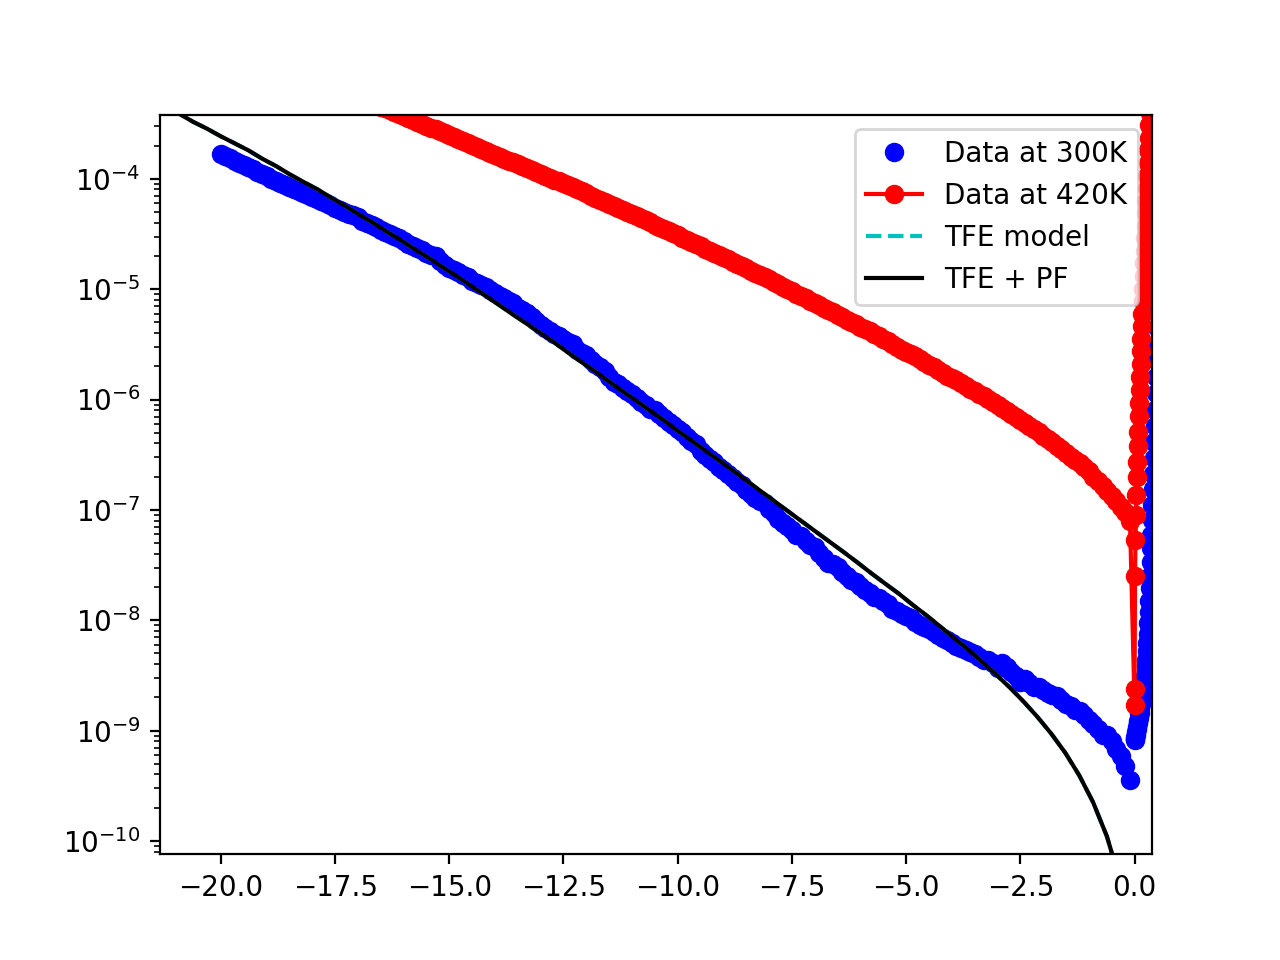

In [14]:
fig = plt.figure()
ax = fig.add_subplot()

ax.set_yscale('log')
ax.plot(df['v300'], df['j300'], 'bo', label = 'Data at 300K')

ax.plot(df['v420'], df['j420'], 'ro-', label = 'Data at 420K')

_v = np.linspace(0, -30, 100)
J_TFE = get_TFE(_v, Temp = 300., meff=meff, mt = 0.256, bi = 1., phib = 1.055, Nd=Nd, FE_off = False)

F = [get_F(0, i, bi = bi, Nd = Nd) for i in _v]
F = np.asarray(F)

A = 3e-13
J_PF = A*F*np.exp(-q/kB/Temp*(0.29 - np.sqrt(q*F/pi/eps)))

ax.plot(_v, np.abs(J_TFE), 'c--', label = 'TFE model')
#ax.plot(_v , F, 'k--')
#ax.plot(_v,  np.abs(J_PF), 'm--', label = 'PF model')

ax.plot(_v, np.abs(J_TFE+J_PF*0), 'k',label = 'TFE + PF')
ax.legend()

Что в итоге? Почему-то токи на -10V не совпадают с измеренымми. Надо подобрать такие параметры `Nd` и `Vbi` чтобы токи сошлись с экспериментом, или проверить модель в соотвествии с сылками, нет ли где опечатки и т.п.

<IPython.core.display.Javascript object>


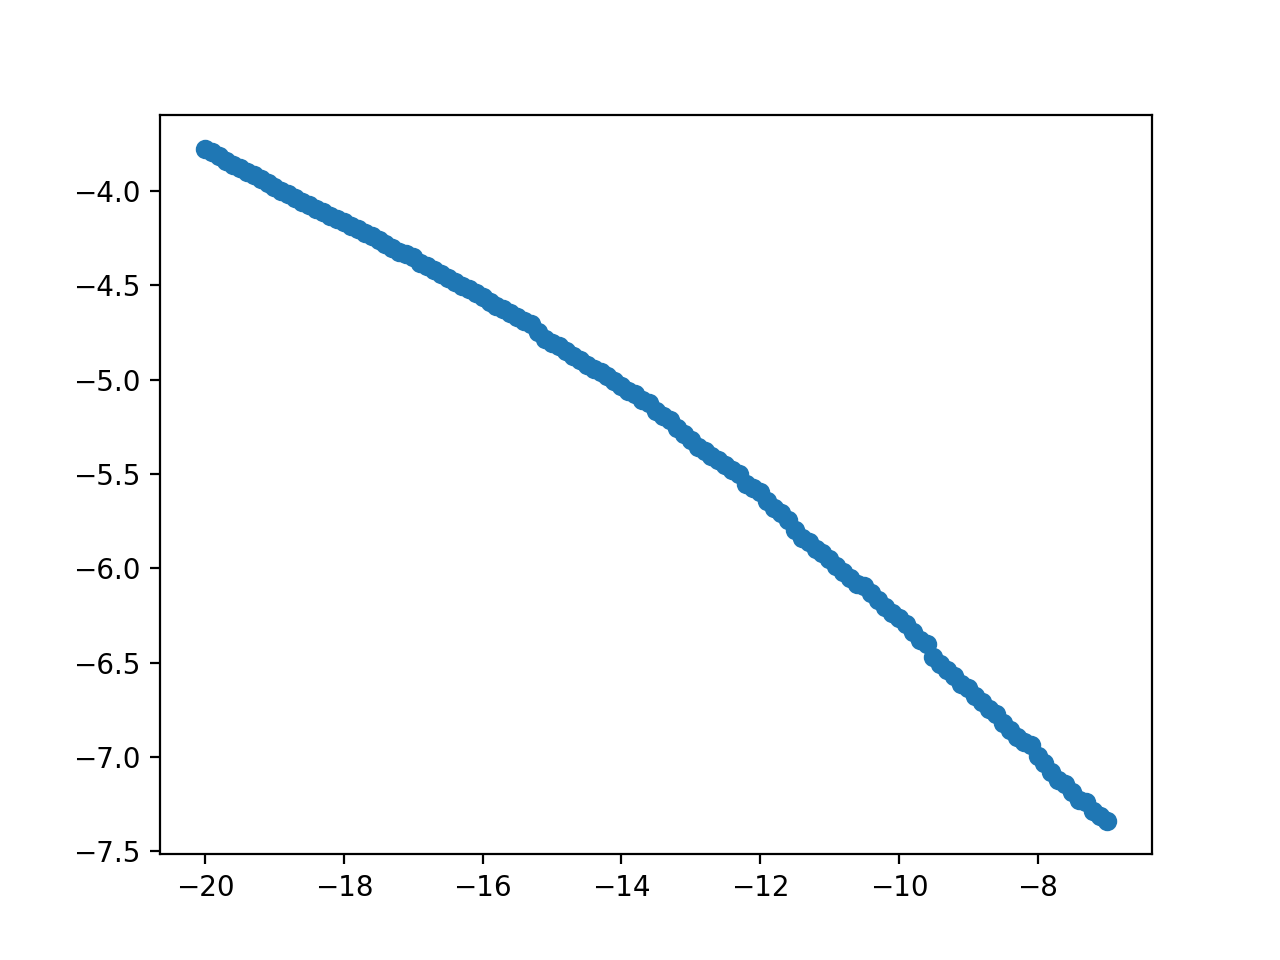

In [11]:
v = df[df['v300'] <= -7.0]['v300'][::]
j = df[df['v300'] <= -7.0]['j300'][::]

fig = plt.figure()
plt.plot(v, np.log10(j), 'o')

In [12]:
#            mt, bi, phib
p0     = [  0.1, 0.9, 1.2]
bounds = [[0.01, 0.2, 0.3],
          [   1, 1.5, 1.8]]


def fit_lnJ(_v, _mt, _bi, _phib):
    J = get_TFE(_v, Temp = 300., meff=meff, mt = _mt, bi = 1., phib = _phib, Nd=Nd)
    return np.log10(np.abs(J))

popt, pcov = curve_fit(fit_lnJ, v, np.log10(j), p0 = p0, bounds = bounds)
popt

array([0.25619015, 1.29630082, 1.0559894 ])

<IPython.core.display.Javascript object>


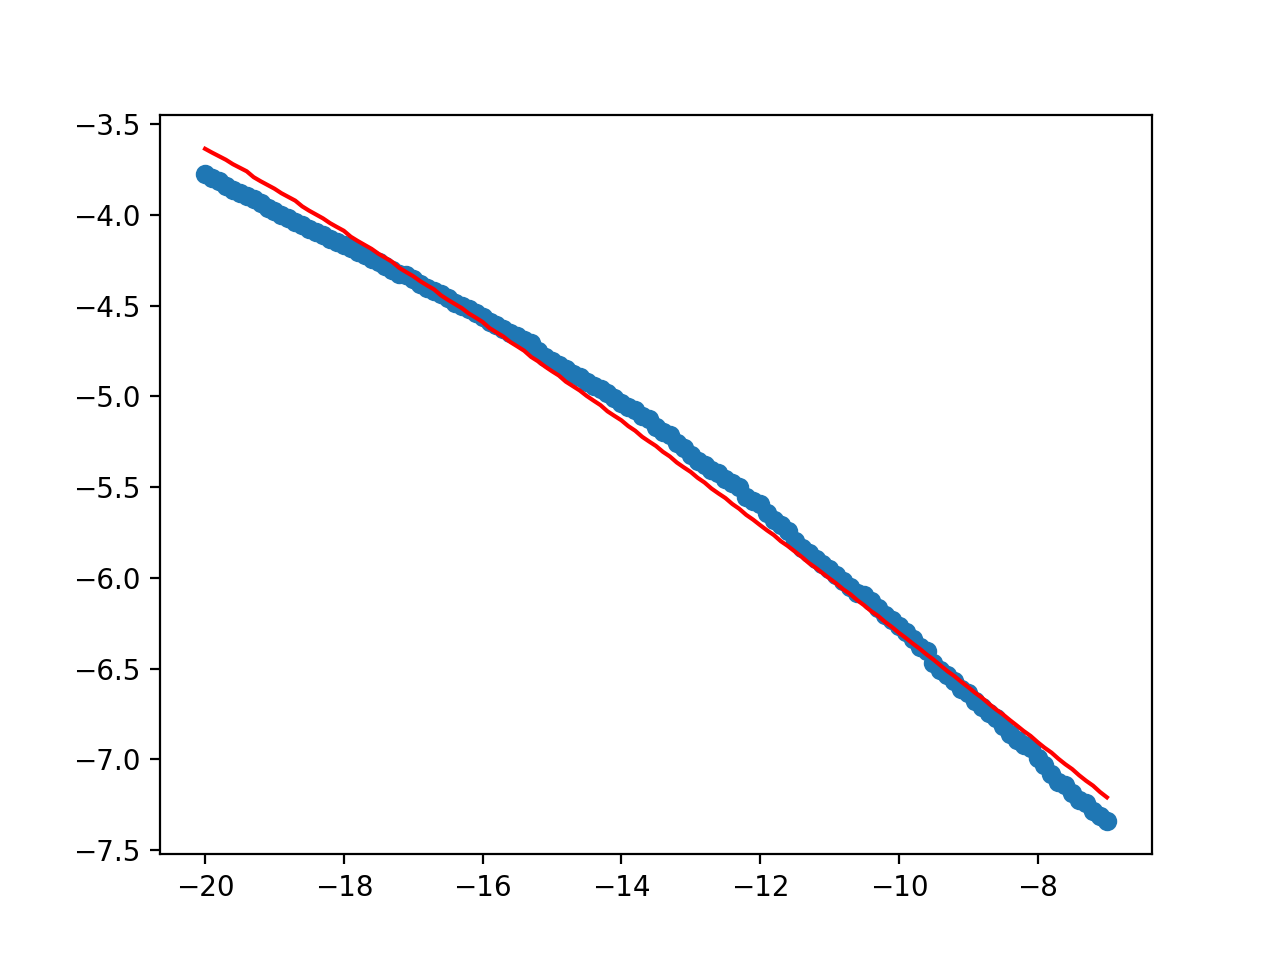

In [13]:
fig = plt.figure()
plt.plot(v, np.log10(j), 'o')
plt.plot(v, fit_lnJ(v, *popt), 'r-')